# DS4A Project - Airlines Revenue  
 

**Objective**: Provide solutions for airline companies for forecast quarterly revenue, and understand the casual relationship between airline companies' revenue and a few of explanatory factors. 

In [0]:
# Gets datasets and imports them into Colab 
%%capture 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QqQZ14Z7agy2sZQZUCtzhrnc_pnDn0z5' -O 'flight_traffic.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IfKvqwJe8sBqM81oMhqwL5JUU0hLZ8RK' -O 'fares.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CyC7RcxD2zmlrsSJcNfw9-sAHTp4HNm0' -O 'events_US.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IJ8-Uqe_62nzkdB812mPVquiTPXFFgj9' -O 'airlines.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jz-lbtaaAEhsa2rLKQq5kaFiipg-f3B_' -O 'airports.csv'

In [0]:
import pandas as pd 
import math 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.graph_objects as go
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
from matplotlib import colors as mcolors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def load_data():
  '''
  Loads the data and returns python dataframe
  '''
  airlines = pd.read_csv('airlines.csv')
  events = pd.read_csv('events_US.csv', encoding='latin-1')
  fares = pd.read_csv('fares.csv')
  flight = pd.read_csv('flight_traffic.csv')
  airports = pd.read_csv("airports.csv", encoding='latin-1')

  return airlines, events, fares, flight, airports

airlines, events, fares, flight, airports = load_data()

## **0. Initial checking** 

In [0]:
flight['airline_id'].unique()

array(['AA', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', 'OO', 'UA', 'WN', 'AS',
       'VX'], dtype=object)

The `flight` table only contains the flights of 12 airline companies, and all of them are U.S domestic. 

## **1. Data preprocessing**

**1). For `fares` table, drop rows with airline_id == `'--'`.**













In [0]:
fares['airline_id'].unique()

array(['AA', 'DL', 'UA', '--', 'WN', 'HA', 'AS', '9K', 'BB', 'KS', 'ZK',
       'VX', '3M', 'B6', 'MW', 'SY', 'WP', '7H', 'F9', 'NK', 'OO', 'C5',
       'G4', 'VS', 'NZ', 'EI', 'VA', 'LA', 'TP', 'QF', 'NH', 'AF', 'YX',
       'OZ', 'AC', 'YV', 'SQ', '4B', 'FI', 'BA', 'MH', 'LY', 'WS', 'LH',
       'QR', 'KL', 'SK', 'EK', 'OK', 'G3', 'JL', 'TK', 'EV', 'SN', 'CZ',
       'PR', 'EY', 'AV', 'QX', 'JJ'], dtype=object)

In [0]:
fares = fares[fares['airline_id'] != '--']

**2). For `flight` table,  create a new column variable `quarter`**
 

In [0]:
quarter = []
for i in flight['month']:
  if i <= 3:
    quarter.append(1)
  elif i <= 6:
    quarter.append(2)
  elif i <= 9:
    quarter.append(3)
  else:
    quarter.append(4)
flight['quarter'] = quarter 

**3) For `flight` table, create a new column variable `flight_route`**

In [0]:
flight['flight_route'] = flight['origin_airport'] + ' --> ' + flight['destination_airport']

**3) Computed quarterly revenue for every airline company**


In [0]:
# Calculate the quarterly revenue for an airline of a company 
fare_bucket = list(fares.iloc[:,5:].columns)
temp, fares_by_route = fares.iloc[:,0:5].copy(), fares.iloc[:,0:5].copy()
revenue = []

for i in np.arange(len(fare_bucket)):
  temp[int(fare_bucket[i])] = fares.iloc[:,5+i] * int(fare_bucket[i])
for j in np.arange(len(fares)):
  revenue.append(sum(temp.iloc[j,5:]))

fares_by_route['quarterly_revenue'] = revenue

# Calculate the quarterly revenue for each airline company 
fares_by_company = fares_by_route.groupby(['airline_id', 'quarter']).sum()[['quarterly_revenue']].reset_index()

In [0]:
fares_by_route.head()

,quarter,airline_id,origin_airport,destination_airport,distance,quarterly_revenue
0,1,AA,CLT,SGF,708,98510
1,1,DL,DTW,SAN,1956,1041350
2,1,DL,MSP,ISN,546,74660
3,1,AA,CLT,RDU,130,183630
4,1,DL,ATL,RIC,481,910770


In [0]:
fares_by_company.head()

,airline_id,quarter,quarterly_revenue
0,3M,1,65450
1,3M,2,122730
2,3M,3,76430
3,3M,4,54090
4,4B,2,6130


**4) Computed number of passenger per flight per quarter**

In [0]:
passenger = []
for k in np.arange(len(fares)):
  passenger.append(sum(fares.iloc[k,5:]))
fares_by_route['passenger_per_quarter'] = passenger

## **2. EDA**

To understand what factors impact the quarterly revenue of a airline company, we will explore the following features:

- Total number of flights per quarter
- Total number of distinct routes per quarter 
- How many popular routes operated by the company per quarter
- Average price per passenger 




### **1) Total number of flights per quarter**

Hypothesis: *Having more flights may lead to higher revenue in that quarter*

In [0]:
# Total number of flights per quarter per airline id 
flight_per_quarter = flight.groupby(["quarter", "airline_id"]).size().reset_index(name = 'number_of_flight_per_quarter')

# Joins with fares_by_company
quarter_revenue_num_flight = pd.merge(fares_by_company, flight_per_quarter, how = 'inner', on = ['quarter', 'airline_id'])
quarter_revenue_num_flight.head()

,airline_id,quarter,quarterly_revenue,number_of_flight_per_quarter
0,AA,1,706493640,21930
1,AA,2,819721540,22800
2,AA,3,752466610,23173
3,AA,4,786687090,22016
4,AS,1,180126550,4351


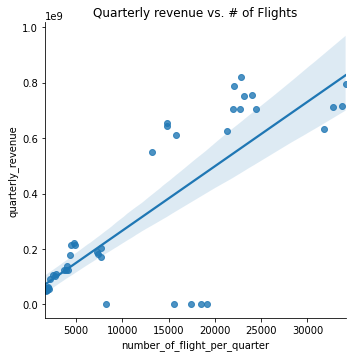

In [0]:
sns.lmplot(x = 'number_of_flight_per_quarter', 
            y = 'quarterly_revenue', 
            data = quarter_revenue_num_flight)

ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of Flights');             

We do observe a generally positive correlation as we expected. However, there're five points in the bottom that significantly deviate from our regression line. We will further look into that. 

In [0]:
quarter_revenue_num_flight.sort_values("quarterly_revenue").head(5)

,airline_id,quarter,quarterly_revenue,number_of_flight_per_quarter
16,EV,3,300,8204
32,OO,4,25040,18508
31,OO,3,71420,19193
29,OO,1,84880,15587
30,OO,2,1150520,17452


In [0]:
airlines[(airlines['airline_id'] == 'EV') | (airlines['airline_id'] =='OO')]

,airline_id,airline_name
19,OO,SkyWest Airlines
51,EV,ExpressJet Airlines Inc.


Both SkyWest Airlines and ExpressJet Airlines are **subsidary/contractor** of other big airline companies. They are different from the other 10 mainline companies in the `flight` table so removing these outliers seems to be a resonable approach since our focus is to **predict revenue for mainline companies.**

In [0]:
# Removes 'OO' and 'EV' from all the tables used for analysis 
airlines = airlines[(airlines['airline_id'] != 'EV') & (airlines['airline_id'] !='OO')]
fares_by_company = fares_by_company[(fares_by_company['airline_id'] != 'EV') & (fares_by_company['airline_id'] !='OO')]
filtered_quarter_revenue_num_flight = quarter_revenue_num_flight[(quarter_revenue_num_flight['airline_id'] != 'EV') & 
                           (quarter_revenue_num_flight['airline_id'] != 'OO')]                          

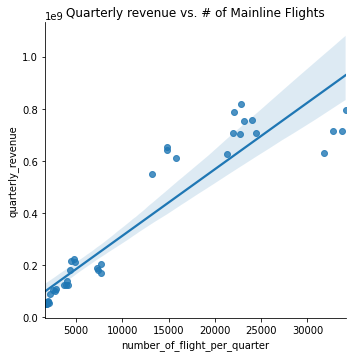

In [0]:
sns.lmplot(x = 'number_of_flight_per_quarter', 
            y = 'quarterly_revenue', 
            data = filtered_quarter_revenue_num_flight)
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of Mainline Flights');

- There is a positive correlation between the number of flights and the quarterly revenue. 
- Companies with 150k-250k flights per quarter had roughly the same(or even more) revenue as companies with more than 350k flights. 

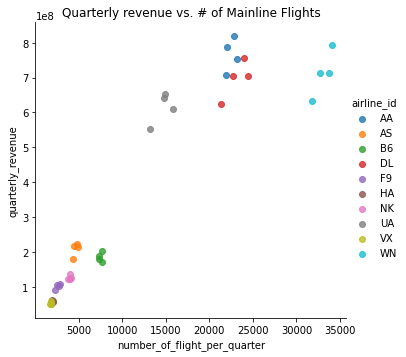

In [0]:
sns.lmplot(x = 'number_of_flight_per_quarter', 
            y = 'quarterly_revenue', 
            fit_reg=False,
            hue = 'airline_id',
            data = filtered_quarter_revenue_num_flight); 
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of Mainline Flights'); 

- Adding `airline_id` as a color factor, we can roughly group companies into three clusters based on the number of flight per quarter.  
  - Low: companies with < 100k flights per quarter(Ex. Alaska, JetBlue) 
  - Medium: companies with 150k - 250k flights per quarter(Ex. AA, Delta, UA) 
  - High: companies with > 350k flights per quarter(Southwest)  





### **2) Total number of distinct flight routes per quarter**

*Hypothesis: companies with more diverse flight routes may have generated more revenue in that quarter.*

In [0]:
# Distinct light routes per quarter per airline id
route_by_company = flight[['quarter', 'airline_id', 'flight_route']].drop_duplicates()
route_by_company.head()

,quarter,airline_id,flight_route
0,1,AA,CLT --> PHX
1,1,AA,FLL --> CLT
5,1,AA,RSW --> CLT
6,1,AA,CLT --> ATL
7,1,AA,PBI --> CLT


In [0]:
numb_route_per_id = route_by_company.groupby(['airline_id', 'quarter']).size().reset_index(name = 'number_of_route_per_quarter')
numb_route_per_id.head(8)

,airline_id,quarter,number_of_route_per_quarter
0,AA,1,653
1,AA,2,685
2,AA,3,678
3,AA,4,688
4,AS,1,248
5,AS,2,260
6,AS,3,254
7,AS,4,264


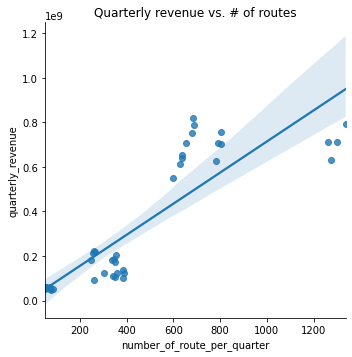

In [0]:
# Joins with fares_by_company
quarter_revenue_num_route = pd.merge(numb_route_per_id, fares_by_company, how = 'inner', on = ['quarter', 'airline_id'])
sns.lmplot(x = 'number_of_route_per_quarter', 
            y = 'quarterly_revenue', 
            data = quarter_revenue_num_route)
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of routes'); 

- There is a positive correlation between the number of routes and the quarterly revenue. 
- Companies with 600-800 routes per quarter had roughly the same(or even more) revenue as companies with more than 1200 routes.  

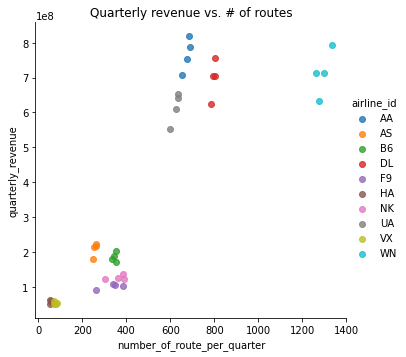

In [0]:
sns.lmplot(x = 'number_of_route_per_quarter', 
            y = 'quarterly_revenue', 
            fit_reg=False,
            hue = 'airline_id',
            data = quarter_revenue_num_route)
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of routes'); 

- Similar to what we had in part 1), three clusters are defined as follows:
  - Low: companies with < 400 routes per quarter(Ex. Alaska, JetBlue) 
  - Medium: companies with 600-800 routes per quarter(Ex. AA, Delta, UA) 
  - High: companies with > 1200 routes per quarter(Southwest)  

Combined with what we've found in part 1), we conclude that: 

- **More flights or more routes are not necessarily indicative of high revenue**: some companies in the medium range of `Number of flight` and `Number of routes` also yield fair amount of revenue(Ex. AA, Delta, UA), which leads to our next question: what factors could be indicative of the revenue of a company?

### **3) Number of popular routes per quarter**

To define what 'popular routes' are, we first need to define 'popular flight origin and destination'. 

In [0]:
top_10_origin = flight.groupby('origin_airport').size().reset_index(name = 'number_of_flights').sort_values('number_of_flights', ascending = False)
top_10_origin.head(10)

,origin_airport,number_of_flights
20,ATL,36275
223,ORD,26707
81,DEN,22529
171,LAX,21689
82,DFW,18117
274,SFO,17621
235,PHX,15282
169,LAS,15196
273,SEA,13666
211,MSP,13542


In [0]:
top_10_destination = flight.groupby('destination_airport').size().reset_index(name = 'number_of_flights').sort_values('number_of_flights', ascending = False).head(10)
top_10_destination.head(10)

,destination_airport,number_of_flights
20,ATL,36219
224,ORD,26663
82,DEN,22540
172,LAX,21549
83,DFW,18144
275,SFO,17217
236,PHX,15589
170,LAS,15127
274,SEA,13818
212,MSP,13479


The`top_10_origin` are actually the same as `top_10_destination`. We will use `top_10_destination` for now. 

We define `popular_route` as **both the flight origin or the destination are in the `top_10_destination` list**. 

In [0]:
popular_flight = flight[(flight['origin_airport'].isin(top_10_destination['destination_airport'])) &
       (flight['destination_airport'].isin(top_10_destination['destination_airport']))]
popular_flight_count = popular_flight[['quarter', 'airline_id', 'flight_route']].drop_duplicates().groupby(['quarter', 'airline_id']).count().reset_index()
popular_flight_count.head()

,quarter,airline_id,flight_route
0,1,AA,58
1,1,AS,18
2,1,B6,2
3,1,DL,50
4,1,EV,3


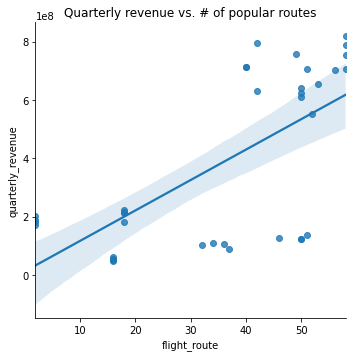

In [0]:
# Joins with fares_by_company
quarter_revenue_num_route = pd.merge(popular_flight_count, fares_by_company, how = 'inner', on = ['quarter', 'airline_id'])
sns.lmplot(x = 'flight_route', 
            y = 'quarterly_revenue', 
            data = quarter_revenue_num_route)
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of popular routes'); 

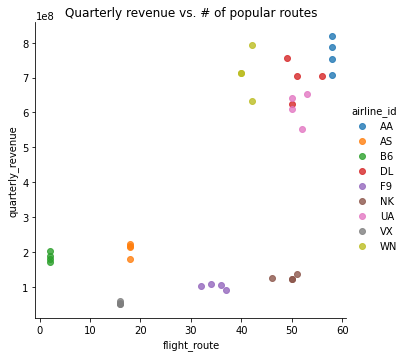

In [0]:
quarter_revenue_num_route = pd.merge(popular_flight_count, fares_by_company, how = 'inner', on = ['quarter', 'airline_id'])
sns.lmplot(x = 'flight_route', 
            y = 'quarterly_revenue',
            fit_reg=False, 
            hue = 'airline_id',
            data = quarter_revenue_num_route)
ax = plt.gca()
ax.set_title('Quarterly revenue vs. # of popular routes'); 

Here, we observe that companies with more popular routes do have higher quarterly revenue. 

However, companies like F9(Frontier) and NK(Spirit) have fair number of popular routes, they seem to have very low revenue. On the contrary, WN(SouthWest) and UA(united airline) have very similar values in the number of popular flight but significantly higher revenue

We will further investigate into such a difference. 

### **4) Average price per seat** 

Now we want to compare `average price per seat` of F9 and NK with WN and UA, by looking at the histograms. 

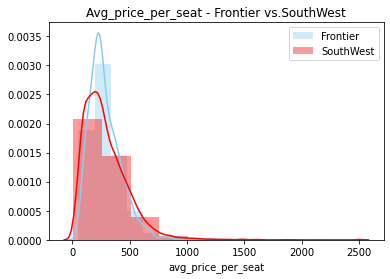

In [0]:
fares_by_route['avg_price_per_seat'] = fares_by_route['quarterly_revenue'] / fares_by_route['passenger_per_quarter']
F9 = fares_by_route[fares_by_route['airline_id'] == 'F9']['avg_price_per_seat']
NK = fares_by_route[fares_by_route['airline_id'] == 'NK']['avg_price_per_seat']
AA = fares_by_route[fares_by_route['airline_id'] == 'UA']['avg_price_per_seat']
WN = fares_by_route[fares_by_route['airline_id'] == 'WN']['avg_price_per_seat']

sns.distplot(F9, bins=10, color = 'skyblue', label = 'Frontier').set_title('Avg_price_per_seat - Frontier vs. SouthWest')
sns.distplot(WN, bins=10,  color = 'red', label = 'SouthWest').set_title('Avg_price_per_seat - Frontier vs.SouthWest')
plt.legend();

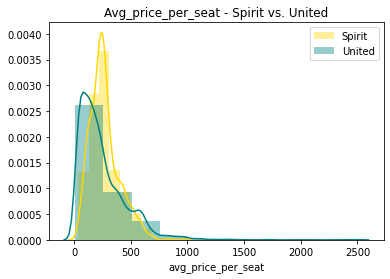

In [0]:
sns.distplot(NK, bins=10, color = 'gold', label = 'Spirit').set_title('Avg_price_per_seat - Spirit vs. United')
sns.distplot(AA, bins=10,  color = 'teal', label = 'United').set_title('Avg_price_per_seat - Spirit vs. United')
plt.legend();

The distributions of average price per seat for low-cost carriers and high-cost carriers are skewed to the right, indicating that most of their price ticket per person fall below `$500`. 

However, for high-cost carriers like United Airline and SouthWest, there is a very long tail all the way to the right end at `$2500`, whereas low-cost carriers do not have tail that goes beyond `$1500`. Also, high-cost carriers have more tickets in the bucket from `$500` to `$1000` than low-cost carriers do. 

Now let's look at the flights with unusually high price(>`$2000`) but very small number of passengers(< 3). 

We'll call them `private flight`.

In [0]:
fares_by_route[(fares_by_route['avg_price_per_seat'] > 1500) &
               (fares_by_route['passenger_per_quarter'] < 3)]['airline_id'].unique()
# QF is an Australian airline company so we'll exclude it from our list bc we're mainly focused with U.S domestic companies. 

array(['AA', 'UA', 'WN', 'DL', 'QF'], dtype=object)

It turns out that companies that operate private flights are those with the highest revenue !

### **5) Long vs. Short distance flight**

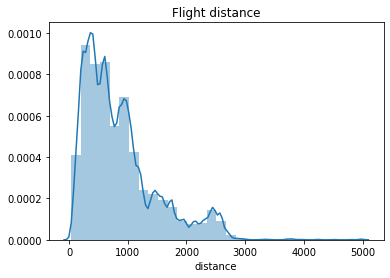

In [0]:
sns.distplot(flight['distance'], bins = 30).set_title('Flight distance');

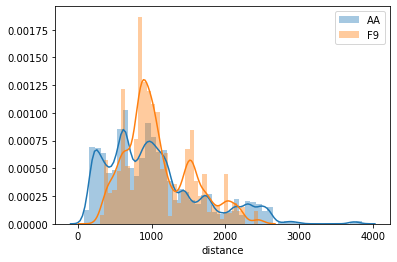

In [0]:
sns.distplot(flight[flight['airline_id'] == 'AA']['distance'], label  = 'AA')
sns.distplot(flight[flight['airline_id'] == 'F9']['distance'], label = 'F9')
plt.legend();

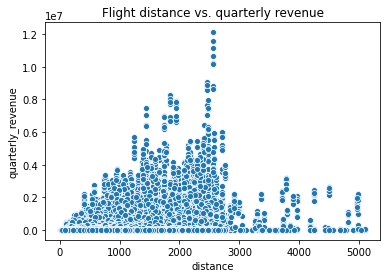

In [0]:
sns.scatterplot(x = 'distance', y = 'quarterly_revenue', data = fares_by_route).set_title("Flight distance vs. quarterly revenue");


## **3. Visualization**

### **1) All U.S airports traffic volume**

There are 322 airports in the dataset. 

Let's find out what their traffic volume in 2017 look like.  



In [0]:
  flight_subset = flight[flight['airline_id'] == 'WN'][['airline_id', 'origin_airport', 'destination_airport']]
  airports_subset = airports[['airport_id', 'airport_name', 'latitude', 'longitude']]
  join_origin = pd.merge(flight_subset, airports_subset, how = 'inner', left_on = 'origin_airport', right_on='airport_id').rename(columns = {'latitude': 'departure_lat', 'longitude': 'departure_lon'})
  join_origin_destination = pd.merge(join_origin, airports_subset, how = 'inner', left_on = 'destination_airport', right_on = 'airport_id').rename(columns = {'latitude': 'arrival_lat', 'longitude': 'arrival_lon'})
  dep_cnt = join_origin_destination.groupby(['departure_lat', 'departure_lon', 'airport_name_x']).size().reset_index(name = 'airport_dep_flight')
  arr_cnt = join_origin_destination.groupby(['arrival_lat', 'arrival_lon', 'airport_name_y']).size().reset_index(name = 'airport_arr_flight')
  routes = pd.merge(dep_cnt, arr_cnt, left_on= ['departure_lat', 'departure_lon'], right_on = ['arrival_lat', 'arrival_lon'])
  routes['total_flight'] = routes['airport_dep_flight'] + routes['airport_arr_flight']
  routes = routes[['departure_lat', 'departure_lon', 'airport_name_x', 'airport_dep_flight', 'airport_arr_flight', 'total_flight']].rename(columns = {'departure_lat': 'lat', 'departure_lon': 'lon', 'airport_name_x': 'airport_name'})

In [0]:
routes['text'] = routes['airport_name'] +  '<br>' + 'Total: ' + \
routes['total_flight'].astype(str) + '<br>' + 'Incoming: ' + routes['airport_arr_flight'].astype(str) + \
'<br>' + 'Outgoing: '+ routes['airport_dep_flight'].astype(str)
limits = [(0, 1000), (1001, 5000), (5001, 10000), (10001, 50000), (50001, 80000)]
fig1 = go.Figure()
scale = 50

for i in range(len(limits)):
  lim = limits[i]
  df_sub = routes[(routes['total_flight'] < lim[1]) &
                  (routes['total_flight'] > lim[0])]
  fig1.add_trace(go.Scattergeo(
      locationmode = 'USA-states',
      lon = df_sub['lon'],
      lat = df_sub['lat'],
      hoverinfo = 'text',
      text = df_sub['text'],
      mode = 'markers',
      marker = dict(
              size = df_sub['total_flight']/scale,
              color = 'royalblue',
              line_color='rgb(40,40,40)',
              line_width=1,
              sizemode = 'area'
          ),
      name = '{0} - {1}'.format(lim[0],lim[1])))

  fig1.update_layout(
      title_text = 'All U.S airports and the traffic volume - 2017',
      showlegend = False,
      geo_scope='usa'
  )

fig1.show()

### **2) All Flight routes**

Let's look at all flight routes in the dataset. 

In [0]:
flight_routes = join_origin_destination.groupby(['airport_name_x', 'departure_lat', 'departure_lon', 
                          'airport_name_y', 'arrival_lat', 'arrival_lon']).size().reset_index(name = 'total_flight')  
popular_flight = flight_routes.sort_values(by = 'total_flight', ascending = False)
copy_pop_flight = popular_flight.copy()

cnt_dict = dict()
agg_dict = dict()
for i in np.arange(len(copy_pop_flight)): 
  path_key = sorted([copy_pop_flight['airport_name_x'].iloc[i], copy_pop_flight['airport_name_y'].iloc[i]])
  sorted_path_key = path_key[0] + path_key[1]
  if sorted_path_key not in cnt_dict:
    cnt_dict[sorted_path_key] = popular_flight['total_flight'].iloc[i]
  else:
    cnt_dict[sorted_path_key] += popular_flight['total_flight'].iloc[i]
    agg_dict[copy_pop_flight.index[i]] = cnt_dict[sorted_path_key]

for k in agg_dict.keys():
  copy_pop_flight.loc[k, 'total_flight'] = agg_dict[k]
  
popular_flight = copy_pop_flight.loc[agg_dict.keys(), :]

In [0]:
fig2 = go.Figure()
colors = ['orange', 'crimson']
limits  = [(0, 1700), (1701,  4000)]
hover = ['skip', 'text']

for i in np.arange(len(popular_flight)):
  fig2.add_trace(
      go.Scattergeo(
          locationmode = 'USA-states',
          lon = [popular_flight['departure_lon'].iloc[i], popular_flight['arrival_lon'].iloc[i]],
          lat = [popular_flight['departure_lat'].iloc[i], popular_flight['arrival_lat'].iloc[i]],
          hoverinfo = 'skip',
          text = 'Departure: '  + popular_flight['airport_name_x'].iloc[i] + '<br>' + \
                  'Arrivals: ' + popular_flight['airport_name_y'].iloc[i] + '<br>' + \
                  'Flights: ' + popular_flight['total_flight'].astype(str).iloc[i],
          mode = 'lines',
          line = dict(width = 1,
                      color = 'red'),
          opacity = float(popular_flight['total_flight'].iloc[i]) / float(popular_flight['total_flight'].max()),
      )
  )

fig2.update_layout(
    title_text = 'All flight paths in 2017',
    showlegend = False,
    geo = dict(
        scope = 'usa',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig2.show()

As we can see in the plot above, the bolder the line is, the higher traffic volume it indicates to be. 

**Some of the most popular routes are:**

1) SFO <-> LA 

2) LA <-> NYC 

3) NYC <-> ATL

### **3) American Airline Flight Routes** 


In [0]:
AA = join_origin_destination[join_origin_destination['airline_id'] == 'WN']
flight_routes  =  AA.groupby(['airport_name_x', 'departure_lat', 'departure_lon', 
                          'airport_name_y', 'arrival_lat', 'arrival_lon']).size().reset_index(name = 'total_flight')  
popular_flight = flight_routes.sort_values(by = 'total_flight', ascending = False)
copy_pop_flight = popular_flight.copy()

cnt_dict = dict()
agg_dict = dict()
for i in np.arange(len(copy_pop_flight)): 
  path_key = sorted([copy_pop_flight['airport_name_x'].iloc[i], copy_pop_flight['airport_name_y'].iloc[i]])
  sorted_path_key = path_key[0] + path_key[1]
  if sorted_path_key not in cnt_dict:
    cnt_dict[sorted_path_key] = popular_flight['total_flight'].iloc[i]
  else:
    cnt_dict[sorted_path_key] += popular_flight['total_flight'].iloc[i]
    agg_dict[copy_pop_flight.index[i]] = cnt_dict[sorted_path_key]

for k in agg_dict.keys():
  copy_pop_flight.loc[k, 'total_flight'] = agg_dict[k]
  
popular_flight = copy_pop_flight.loc[agg_dict.keys(), :]

# initialize figure 
fig2 = go.Figure()
colors = ['orange', 'crimson']
limits  = [(0, 1700), (1701,  4000)]
hover = ['skip', 'text']

for i in np.arange(len(popular_flight)):
  fig2.add_trace(
      go.Scattergeo(
          locationmode = 'USA-states',
          lon = [popular_flight['departure_lon'].iloc[i], popular_flight['arrival_lon'].iloc[i]],
          lat = [popular_flight['departure_lat'].iloc[i], popular_flight['arrival_lat'].iloc[i]],
          hoverinfo = 'skip',
          text = 'Departure: '  + popular_flight['airport_name_x'].iloc[i] + '<br>' + \
                  'Arrivals: ' + popular_flight['airport_name_y'].iloc[i] + '<br>' + \
                  'Flights: ' + popular_flight['total_flight'].astype(str).iloc[i],
          mode = 'lines',
          line = dict(width = 1,
                      color = 'red'),
          opacity = float(popular_flight['total_flight'].iloc[i]) / float(popular_flight['total_flight'].max()),
      )
  )

fig2.update_layout(
    title_text = 'All SouthWest flight paths in 2017',
    showlegend = False,
    geo = dict(
        scope = 'usa',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig2.show()

## **4) K-Means Clustering**

In our analysis in part 2), there seems to exist distinct groups of airline companies based on quarterly revenue,number of flights, number of routes, number of popular routes and average price per seat.  

In [0]:
tmp1 = pd.merge(quarter_revenue_num_flight, numb_route_per_id, on = ['airline_id', 'quarter'])
tmp2 = pd.merge(tmp1, popular_flight_count, on = ['airline_id', 'quarter'])
join = tmp2[~tmp2['airline_id'].isin(['OO', 'EV'])]

In [0]:
# normalization using min - max scaling method  

def normalize(df):
  result = df.copy()
  for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
  return result

df_norm = normalize(join[['quarterly_revenue','number_of_flight_per_quarter',
                                'number_of_route_per_quarter']])

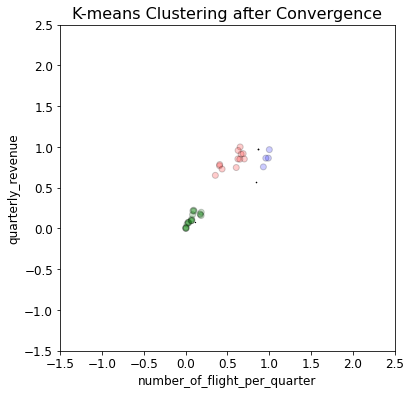

In [0]:
%matplotlib inline
k = 3
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(df_norm)

# Iterative procedure to learn labels  
labels = kmeans.predict(df_norm)
centroids = kmeans.cluster_centers_

# Plot the data learned
colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y', 6:'w'}
fig = plt.figure(figsize=(6, 6))
colors = [colour_map_1[x+1] for x in labels]

plt.scatter(df_norm['number_of_flight_per_quarter'], df_norm['quarterly_revenue'], color=colors, alpha=0.2, edgecolor='k')

for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, marker='*', edgecolor='k')
    
plt.xlabel('number_of_flight_per_quarter', fontsize=12)
plt.ylabel('quarterly_revenue', fontsize=12)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('K-means Clustering after Convergence', fontsize=16)
plt.show()

**Multi-dimensional clustering**

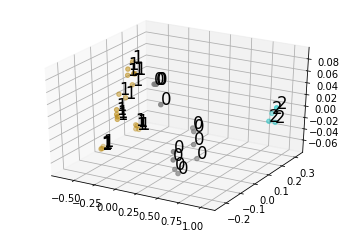

In [0]:
# Principle component analysis 
pca = PCA(3) 
pca.fit(df_norm) 
  
pca_data = pd.DataFrame(pca.transform(df_norm)) 

colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/k) 
cluster_colors = colors[5 : -5 : skips] 

fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 
   
plt.show()

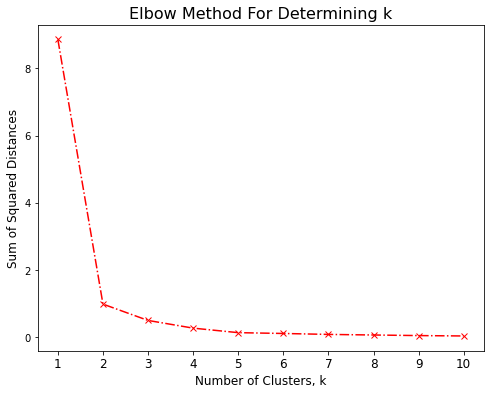

In [0]:
sum_sq_d = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm[['number_of_flight_per_quarter','quarterly_revenue']])
    sum_sq_d.append(km.inertia_)
plt.figure(figsize=(8,6))
plt.plot(K, sum_sq_d, 'rx-.')
plt.xlabel('Number of Clusters, k', fontsize=12)
plt.ylabel('Sum of Squared Distances', fontsize=12)
plt.title('Elbow Method For Determining k', fontsize=16)
plt.xticks(range(1,11), fontsize=12)
plt.show()

## **5) Top Profitable routes for SouthWest**

In [0]:
wn_flight = fares_by_route[fares_by_route['airline_id'] == 'WN']
wn_flight_cnt = flight[flight['airline_id'] == 'WN'].groupby(['quarter', 'origin_airport', 'destination_airport']).size().reset_index(name  = 'flight_cnt')
wn = pd.merge(wn_flight, wn_flight_cnt, on = ['origin_airport', 'destination_airport', 'quarter'])\
.groupby(['airline_id', 'origin_airport', 'destination_airport']).sum().reset_index() \
.rename(columns = {'quarterly_revenue': 'revenue', 
                     'passenger_per_quarter': 'passenger_cnt'})[['airline_id', 'origin_airport', 
                                                                 'destination_airport', 'revenue', 'passenger_cnt', 'flight_cnt', 'distance']]

In [0]:
wn['routes'] = wn['origin_airport'] + '-->' + wn['destination_airport']
other_routes = wn[~wn['routes'].isin(['MDW-->LAS', 'LAS-->MDW', 'MDW-->PHX', 'LAS-->BWI', 'BWI-->LAS'])]

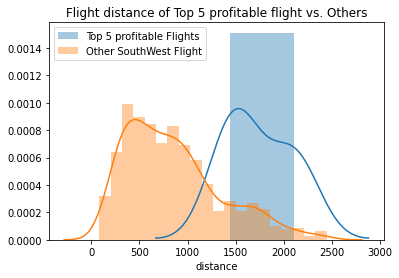

In [0]:
# top 10 profitable routes 
profit_routes = wn.sort_values(['revenue'], ascending=False).head(5)
profit_routes['routes'] = profit_routes['origin_airport'] + '-->' + profit_routes['destination_airport']
sns.distplot(profit_routes['distance']/4, bins = 1,label = 'Top 5 profitable Flights')
sns.distplot(other_routes['distance']/ 4, bins = 20, label = 'Other SouthWest Flight').set_title('Flight distance of Top 5 profitable flight vs. Others');
plt.legend();

In [0]:
profit_routes[['routes', 'revenue', 'passenger_cnt', 'flight_cnt']]

,routes,revenue,passenger_cnt,flight_cnt
814,MDW-->LAS,16758280,43190,308
626,LAS-->MDW,14996270,40849,272
831,MDW-->PHX,14602750,34958,267
605,LAS-->BWI,13264000,25044,184
208,BWI-->LAS,13047610,24927,166


Now we learn about the top 10 profitable routes for SouthWest. We want to see which factor that `revenue` correlates with the most - `passenger_cnt`, `flight_cnt` 

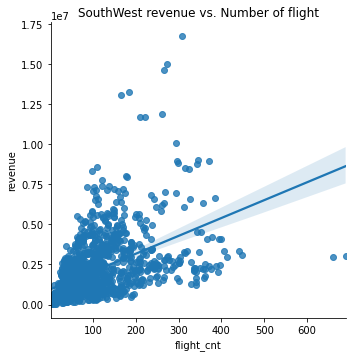

In [0]:
sns.lmplot(x = 'flight_cnt', y = 'revenue', data = wn)
ax = plt.gca()
ax.set_title('SouthWest revenue vs. Number of flight');

In [0]:
# top 10 routes with most number of flights 
wn.sort_values(['flight_cnt'], ascending=False).head(10)

,airline_id,origin_airport,destination_airport,revenue,passenger_cnt,flight_cnt,distance,routes
515,WN,HOU,DAL,3019910,53359,690,956,HOU-->DAL
301,WN,DAL,HOU,2964270,50554,660,956,DAL-->HOU
177,WN,BUR,OAK,3059610,37069,448,1300,BUR-->OAK
668,WN,LAX,OAK,3312450,39486,441,1348,LAX-->OAK
923,WN,OAK,BUR,2990590,36960,412,1300,OAK-->BUR
932,WN,OAK,LAX,3319630,38054,406,1348,OAK-->LAX
1244,WN,SJC,SAN,4097320,38625,398,1668,SJC-->SAN
663,WN,LAX,LAS,2463050,39214,396,944,LAX-->LAS
1166,WN,SAN,OAK,4116220,38316,394,1784,SAN-->OAK
636,WN,LAS,PHX,2005400,33733,392,1020,LAS-->PHX


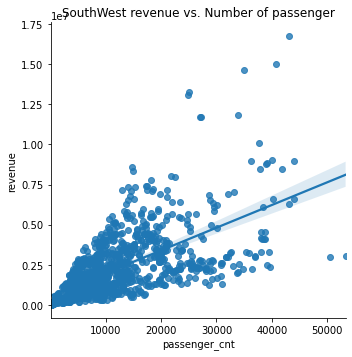

In [0]:
sns.lmplot(x = 'passenger_cnt', y = 'revenue', data = wn)
ax = plt.gca()
ax.set_title('SouthWest revenue vs. Number of passenger');


In [0]:
fares_by_route.to_csv('fares_by_route.csv')

In [0]:
def calc_discrepancy_passenger(airline_id, df):
  '''
  Inputs:  
    airline_id: two-letter id of an airline company. Ex. 'AA'
    df: data frame used for calculation - fares by route

  Outputs:
    df_discrepancy: data frame accounts for flight routes with 
    discrepancies in the number of passengers and discrepancies in revenue
  '''
  filtered_df = df[df['airline_id'] == airline_id].sort_values('revenue', ascending = False)
  temp = filtered_df
  merge = pd.merge(df1, temp,  left_on = ['origin_airport', 'destination_airport'], right_on=['destination_airport',  'origin_airport'])
  merge['discrepancy_#passengers'] = merge['num_of_passengers_x'] - merge['num_of_passengers_y']
  discrepancy_df = merge.drop_duplicates(subset=['discrepancy_#passengers']).sort_values('discrepancy_#passengers', ascending = False)
  discrepancy_df['discrepancy_revenue'] = discrepancy_df['revenue_x'] - discrepancy_df['revenue_y']

  sns.lmplot(x = 'discrepancy_#passengers', y = 'discrepancy_revenue', data = discrepancy_df)
  ax = plt.gca()
  ax.set_title('Discrepancy # Passengers ' + '-- ' + airline_id);

  return discrepancy_df
